<a href="https://colab.research.google.com/github/vinayprabhu/hate_scaling/blob/main/code/2_Pysentimiento_400M_2Ben.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GOAL: The goal of this notebook is to:
- Subsample 16=3.2+12.8 million alt-text descriptions from LAION-400M and LAION2B-En datasets
- Pass it through [pysentimiento](https://arxiv.org/abs/2106.09462) that outputs a 1x3 vector capturing ```['P_hateful', 'P_targeted', 'P_aggressive']```
- Analyze the results and check if QFR (Quality Failure Rate) increases
- A walk-through of all the results and (meta)datasets curated

**(TW)**: Some of the alt-text descriptions you may encounter below are misogynistic and downright 🤮

# 1: Standard imports (This is my customized default first-cell)

In [ ]:
from psutil import virtual_memory
# Make sure to run it on a high-memory instance
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
%matplotlib inline

from scipy.linalg import block_diag
import seaborn as sns
# Numpy aesthetics
np.set_printoptions(suppress=True)
from collections import Counter
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

import itertools
%precision 6
#############################################
import sys
import importlib
importlib.reload(sys)
#######################
from google.colab import drive
drive.flush_and_unmount()
import os
drive.mount('/gdrive', force_remount=True)
# Enter your own proj_dir here
proj_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset/'
os.chdir(proj_dir)

Your runtime has 89.6 gigabytes of available RAM



<ipython-input-1-63d9838edee0>:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina')


Drive not mounted, so nothing to flush and unmount.
Mounted at /gdrive


# Download the LAION datasets

Source: https://laion.ai/laion-400-open-dataset/


*We produced the dataset in several formats to address the various use cases*: 
- A 50GB url+caption metadata dataset in parquet files. This can be used to compute statistics and redownload part of the dataset
- A 10TB webdataset with 256×256 images, captions and metadata. This is a full version of the dataset, that can be used directly for training
- A 1TB set of the 400M text and image clip embeddings, useful to rebuild new knn indices
- Two 4GB knn indices allowing to easily search in the dataset + two higher quality 16GB knn indices (running in the webdemo)
URL and caption metadata dataset.

We provide 32 parquet files of size around 1GB (total 50GB) with the image URLs, the associated texts and additional metadata in the following format:

SAMPLE_ID | URL | TEXT | LICENSE | NSFW | similarity | WIDTH | HEIGHT

where

- SAMPLE_ID:   A unique identifier
LICENSE:   If a Creative Commons License could be extracted from the image data, we name it here like e.g. “creativecommons.org/licenses/by-nc-sa/3.0/” – otherwise you’ll find it here a “?”
- NSFW: CLIP had been used to estimate if the image has NSFW content. The estimation has been pretty conservative, reducing the number of false negatives at the cost of more false positives. Possible values are “UNLIKELY”, “UNSURE” and “NSFW”
- similarity: Value of the cosine similarity between the text and image embedding
- WIDTH and HEIGHT: image size as the image was embedded. Originals that were larger than 4K size were resized to 4K

*This metadata dataset is best used to redownload the whole dataset or a subset of it. The img2dataset tool can be used to efficiently download such subsets*.

Source of the parquet files:
https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/


```
!wget http://3080.rom1504.fr/cah/cah_dataframe_unique/part-00000-4d76554c-2d66-4112-9420-0bb9d725a79d-c000.snappy.parquet
!wget https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
!wget -m -np -c -U "eye02" -w 2 -R "index.html*" "https://the-eye.eu/public/AI/cah/laion400m-met-release/laion400m-meta/"

# LAION-2B-En
!git lfs install
!git clone https://huggingface.co/datasets/laion/laion2B-en
```



After downloading the datasets, your dir-tree should look like:
```
the-eye.eu
├── robots.txt
└── public
    └── AI
        └── cah
            └── laion400m-met-release
                ├── laion400m-meta
                │   ├── part-00000-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00001-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00002-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet
                │   ├── part-00004-5b54c5d5-bbcf-484d-a2ce-0d6f73df1a36-c000.snappy.parquet

```
```
LAION-2Ben
├── laion2B-en
│   ├── .git
│   ├── .gitattributes
│   ├── README.md
│   ├── part-00026-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00056-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00033-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00074-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00019-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00016-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00053-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00099-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00035-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00067-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00098-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00013-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00049-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00073-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00079-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
│   ├── part-00017-5114fd87-297e-42b0-9d11-50f1df323dfa-c000.snappy.parquet
```
Here's the helper func to generate these:

In [ ]:
from pathlib import Path
from itertools import islice

space =  '    '
branch = '│   '
tee =    '├── '
last =   '└── '

def tree(dir_path: Path, level: int=-1, limit_to_directories: bool=False,
         length_limit: int=10000):
    """Given a directory Path object print a visual tree structure"""
    dir_path = Path(dir_path) # accept string coerceable to Path
    files = 0
    directories = 0
    def inner(dir_path: Path, prefix: str='', level=-1):
        nonlocal files, directories
        if not level: 
            return # 0, stop iterating
        if limit_to_directories:
            contents = [d for d in dir_path.iterdir() if d.is_dir()]
        else: 
            contents = list(dir_path.iterdir())
        pointers = [tee] * (len(contents) - 1) + [last]
        for pointer, path in zip(pointers, contents):
            if path.is_dir():
                yield prefix + pointer + path.name
                directories += 1
                extension = branch if pointer == tee else space 
                yield from inner(path, prefix=prefix+extension, level=level-1)
            elif not limit_to_directories:
                yield prefix + pointer + path.name
                files += 1
    print(dir_path.name)
    iterator = inner(dir_path, level=level)
    for line in islice(iterator, length_limit):
        print(line)
    if next(iterator, None):
        print(f'... length_limit, {length_limit}, reached, counted:')
    print(f'\n{directories} directories' + (f', {files} files' if files else ''))


# 2: Data acquaintance:
Let us take a look at the individual parquet files constituting these datasets:

- LAION-400M is split into 32 parquet files
- LAION-2B-En has 128 parquet files

In [ ]:
# parquet_list=[]
# import os
# for root, dirs, files in os.walk(os.getcwd()):
#     for file in files:
#         if file.endswith(".snappy.parquet"):
#              parquet_list.append(os.path.join(root, file))
# len(parquet_list)
# This list has been saved in a nice readable dataframe that you can simply load:
data_dir='/gdrive/My Drive/Colab Notebooks/0_laion_dataset' # This will vary based on your env
df_parquet=pd.read_csv('df_parquet_400m_2b.csv')
df_parquet

,dataset,file_id,file_size_GB,file_loc
0,400m,400m_0,1.6794,./the-eye.eu/public/AI/cah/laion400m-met-relea...
1,400m,400m_1,1.6800,./the-eye.eu/public/AI/cah/laion400m-met-relea...
2,400m,400m_2,1.6792,./the-eye.eu/public/AI/cah/laion400m-met-relea...
3,400m,400m_3,1.6797,./the-eye.eu/public/AI/cah/laion400m-met-relea...
4,400m,400m_4,1.6797,./the-eye.eu/public/AI/cah/laion400m-met-relea...
...,...,...,...,...
155,2B,2B_123,2.5123,./LAION-2Ben/laion2B-en/part-00122-5114fd87-29...
156,2B,2B_124,2.5122,./LAION-2Ben/laion2B-en/part-00104-5114fd87-29...
157,2B,2B_125,2.5120,./LAION-2Ben/laion2B-en/part-00102-5114fd87-29...
158,2B,2B_126,2.5120,./LAION-2Ben/laion2B-en/part-00113-5114fd87-29...


In [ ]:
parquet_list=df_parquet.file_loc.values
df_parquet.groupby('dataset')['file_size_GB'].describe(), df_parquet.groupby('dataset')['file_size_GB'].sum()

(         count      mean       std     min       25%     50%     75%     max
 dataset                                                                     
 2B       128.0  2.512508  0.000356  2.5116  2.512275  2.5125  2.5128  2.5132
 400m      32.0  1.679731  0.000330  1.6792  1.679500  1.6797  1.6800  1.6806,
 dataset
 2B      321.6010
 400m     53.7514
 Name: file_size_GB, dtype: float64)

In [ ]:
parquet_list_400m=parquet_list[0:32]
parquet_list_2b=parquet_list[32:]
file_0_400m=parquet_list_400m[0]
file_0_2b=parquet_list_2b[0]

In [ ]:
!pip install --quiet pytictoc
from pytictoc import TicToc
t = TicToc()

Now, let us look at how the _raw_ parquet files look like:

In [ ]:
t.tic()
df_400m_0 = pd.read_parquet(file_0_400m)
print(df_400m_0.shape)
t.toc()
df_400m_0.head(4)

(12933524, 8)
Elapsed time is 39.860817 seconds.


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
0,1.581282e+12,http://media.rightmove.co.uk/148k/147518/58718...,View EPC Rating Graph for this property,109.0,100.0,?,UNSURE,0.312813
1,1.060015e+12,https://thumbs.ebaystatic.com/images/g/DYEAAOS...,Silverline Air Framing Nailer 90mm 10 - 12 Gau...,225.0,225.0,?,UNLIKELY,0.312485
2,3.372497e+12,https://farm1.staticflickr.com/784/40182677504...,Anhui Mountains,800.0,514.0,?,UNLIKELY,0.316512
3,3.820200e+11,https://t2.ftcdn.net/jpg/00/58/35/35/240_F_583...,Acute pain in a woman knee,257.0,240.0,?,UNLIKELY,0.344278


In [ ]:
t.tic()
df_2b_0 = pd.read_parquet(file_0_2b)
print(df_2b_0.shape)
t.toc()
df_2b_0.head(4)

(18141894, 8)
Elapsed time is 64.352866 seconds.


,SAMPLE_ID,URL,TEXT,HEIGHT,WIDTH,LICENSE,NSFW,similarity
0,3.605777e+12,https://i.ebayimg.com/thumbs/images/g/kHAAAOSw...,DAREDEVIL / VOL 1 / 285 / 1990 / MARVEL COMICS...,152.0,225.0,?,UNLIKELY,0.349755
1,7.365890e+11,http://s7d9.scene7.com/is/image/BedBathandBeyo...,Avanti Shower Curtains,400.0,400.0,?,UNLIKELY,0.338636
2,5.892820e+11,https://thumb101.shutterstock.com/image-photo/...,Beautiful young woman wearing white wool hat a...,450.0,320.0,?,UNLIKELY,0.336294
3,3.640733e+12,https://www.hplaptopbattery.com.au/rr_big/pic_...,Battery for HP HSTNN-PB6T laptop,730.0,459.0,?,UNLIKELY,0.340967


Neat! Now ```pip install``` [pysentimiento](https://arxiv.org/abs/2106.09462)

In [ ]:
!pip install --upgrade accelerate
!pip install --quiet pysentimiento==0.5.2
##################################
import sys
print("Python version")
# See: https://github.com/pysentimiento/pysentimiento/issues/50
print (sys.version)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 23.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 115.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.

Getting acquainted with ```pysentimiento```:

Let us initialize the pysentimiento analyzer and feed in an example to see what it produces ...

In [ ]:
from pysentimiento import create_analyzer
analyzer = create_analyzer(task="hate_speech", lang="en")
df_2b_0.TEXT.values[0],analyzer.predict(df_2b_0.TEXT.values[0])
# ('DAREDEVIL / VOL 1 / 285 / 1990 / MARVEL COMICS / US-Comics',
#  AnalyzerOutput(output=[], probas={hateful: 0.017, targeted: 0.012, aggressive: 0.011}))

('DAREDEVIL / VOL 1 / 285 / 1990 / MARVEL COMICS / US-Comics',
 AnalyzerOutput(output=[], probas={hateful: 0.017, targeted: 0.012, aggressive: 0.011}))

In [ ]:
df_400m_0.TEXT.values[0],analyzer.predict(df_400m_0.TEXT.values[0])
# ('View EPC Rating Graph for this property',
#  AnalyzerOutput(output=[], probas={hateful: 0.015, targeted: 0.012, aggressive: 0.011}))

('View EPC Rating Graph for this property',
 AnalyzerOutput(output=[], probas={hateful: 0.015, targeted: 0.012, aggressive: 0.011}))

# 3: The random sampling experiment 

- Generate 0.1 million random indices per parquet file
- Save these 0.1 million random indices of the associated parquet files
- Parse the parquet file and extract the image (alt)textual descriptions pertaining to these 1e5 random indices as a numpy tensor
- Pass the alt-text tensor through the hate-analyzer
- Compute stats and save the results

 Now, let us _for-loop_ over all the (32 + 128) = 160 parquet files

In [ ]:
# Make a directory for the intermediate results
RESULT_DIR='hate_detect_400m_2B-en'
os.makedirs(f'./{RESULT_DIR}/',exist_ok=True)

In [ ]:
np.random.seed(42)
N_samples=int(1e5) # Number of samples you have chosen to randomly sample
N_parquet=len(parquet_list)
N_samples,N_parquet

(100000, 160)

In [ ]:
# For-loop over all the files:
import pyarrow.parquet as pq
qfr_all=np.zeros((N_parquet,3)) # This is a (128 + 32) x 3 file-level QFR (Quality Failure Rate)-matrix
for index_i,file_i in enumerate(parquet_list):
  # 0: Read the parquet file
  # df_i = pd.read_parquet(file_i)
  df_i=pq.read_table(file_i,columns=['TEXT']).to_pandas()
  # 1: Generate random indices for that parquet file
  ind_random_i=np.random.choice(df_i.shape[0],N_samples,replace=False)
  # 2: Extract the text-description from these indices
  texts_np_i = df_i.iloc[ind_random_i].TEXT.astype(str).values[0:N_samples]
  t.tic()
  # 3: Analyze the textual-content ( 1x3 o/p [P_hateful, P_targeted, P_aggressive])
  results_i=analyzer.predict(texts_np_i)
  t.toc()
  # 4: Compute the results
  prob_hate_i=np.array(list(itertools.chain.from_iterable(x.probas.values() for x in results_i))).reshape(N_samples,3)
  qfr_file_i=np.mean(prob_hate_i>0.5,axis=0)*100
  qfr_all[index_i,:]=qfr_file_i
  # 5: Save the intermediate assets for further analysis
  ind_i=file_i.split('/')[-2]+'_'+file_i.split('/')[-1].split('-')[1]
  print(ind_i,qfr_file_i)
  np.save(f'./{RESULT_DIR}/index_random_{ind_i}.npy',ind_random_i)
  np.save(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy',prob_hate_i)
  np.save(f'./{RESULT_DIR}/qfr_file_{ind_i}.npy',qfr_file_i)
  np.save(f'./{RESULT_DIR}/alt_text_{ind_i}.npy',texts_np_i)
  
np.save(f'./{RESULT_DIR}/qfr_400m_2Ben.npy',qfr_all)
df=pd.DataFrame(data=qfr_all,columns=['P_hateful', 'P_targeted', 'P_aggressive'])
df.to_csv('df_qfr_filewise_400M_2B.csv',index=False)

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 121.910137 seconds.
laion400m-meta_00000 [0.294 0.097 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 126.943670 seconds.
laion400m-meta_00001 [0.3   0.069 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 126.909905 seconds.
laion400m-meta_00002 [0.306 0.08  0.011]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 127.423534 seconds.
laion400m-meta_00004 [0.298 0.084 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 127.984459 seconds.
laion400m-meta_00003 [0.303 0.087 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 127.854088 seconds.
laion400m-meta_00005 [0.281 0.08  0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 128.510778 seconds.
laion400m-meta_00006 [0.309 0.082 0.009]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 128.408605 seconds.
laion400m-meta_00007 [0.335 0.105 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 128.499247 seconds.
laion400m-meta_00008 [0.308 0.087 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 129.761054 seconds.
laion400m-meta_00009 [0.294 0.086 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 129.039450 seconds.
laion400m-meta_00010 [0.28  0.076 0.011]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 129.046828 seconds.
laion400m-meta_00011 [0.292 0.08  0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 129.502318 seconds.
laion400m-meta_00012 [0.312 0.103 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 129.240188 seconds.
laion400m-meta_00013 [0.292 0.081 0.011]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 130.856991 seconds.
laion400m-meta_00014 [0.263 0.082 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 130.967694 seconds.
laion400m-meta_00015 [0.297 0.083 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 130.707435 seconds.
laion400m-meta_00016 [0.299 0.08  0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 131.471242 seconds.
laion400m-meta_00017 [0.275 0.079 0.009]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 130.411521 seconds.
laion400m-meta_00018 [0.282 0.098 0.026]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 131.211708 seconds.
laion400m-meta_00019 [0.287 0.076 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 131.095513 seconds.
laion400m-meta_00020 [0.294 0.077 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 132.687169 seconds.
laion400m-meta_00021 [0.295 0.081 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 131.851969 seconds.
laion400m-meta_00022 [0.292 0.094 0.023]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 132.838238 seconds.
laion400m-meta_00023 [0.266 0.078 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 132.127708 seconds.
laion400m-meta_00024 [0.29  0.087 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 133.805109 seconds.
laion400m-meta_00025 [0.285 0.077 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 135.203316 seconds.
laion400m-meta_00026 [0.311 0.084 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 133.319549 seconds.
laion400m-meta_00027 [0.316 0.077 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 133.679663 seconds.
laion400m-meta_00028 [0.302 0.079 0.009]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 134.499210 seconds.
laion400m-meta_00029 [0.317 0.096 0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 135.593084 seconds.
laion400m-meta_00030 [0.304 0.086 0.024]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 134.129257 seconds.
laion400m-meta_00031 [0.326 0.097 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 143.705212 seconds.
laion2B-en_00026 [0.361 0.093 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 143.786282 seconds.
laion2B-en_00056 [0.338 0.11  0.023]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 142.649075 seconds.
laion2B-en_00033 [0.333 0.104 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 143.313285 seconds.
laion2B-en_00074 [0.353 0.101 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 143.959473 seconds.
laion2B-en_00019 [0.333 0.104 0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 144.939205 seconds.
laion2B-en_00016 [0.349 0.112 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.377596 seconds.
laion2B-en_00053 [0.361 0.117 0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 144.482904 seconds.
laion2B-en_00099 [0.327 0.098 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.159420 seconds.
laion2B-en_00035 [0.347 0.116 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 145.901829 seconds.
laion2B-en_00067 [0.349 0.1   0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.107792 seconds.
laion2B-en_00098 [0.337 0.104 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.584739 seconds.
laion2B-en_00013 [0.348 0.106 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.853648 seconds.
laion2B-en_00049 [0.322 0.105 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 145.780413 seconds.
laion2B-en_00073 [0.334 0.12  0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 147.247134 seconds.
laion2B-en_00079 [0.341 0.116 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.017385 seconds.
laion2B-en_00017 [0.38  0.101 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.618245 seconds.
laion2B-en_00039 [0.364 0.111 0.027]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 147.332762 seconds.
laion2B-en_00068 [0.342 0.117 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.123557 seconds.
laion2B-en_00058 [0.35  0.124 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.429802 seconds.
laion2B-en_00047 [0.33  0.095 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.194491 seconds.
laion2B-en_00093 [0.347 0.117 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.569481 seconds.
laion2B-en_00095 [0.333 0.118 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.768903 seconds.
laion2B-en_00070 [0.372 0.113 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.003006 seconds.
laion2B-en_00071 [0.355 0.095 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.348697 seconds.
laion2B-en_00097 [0.372 0.122 0.025]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.253238 seconds.
laion2B-en_00061 [0.345 0.113 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.751825 seconds.
laion2B-en_00078 [0.341 0.124 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.950858 seconds.
laion2B-en_00088 [0.323 0.106 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.263897 seconds.
laion2B-en_00062 [0.371 0.118 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.790851 seconds.
laion2B-en_00072 [0.36  0.119 0.023]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.247196 seconds.
laion2B-en_00002 [0.368 0.113 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 146.886643 seconds.
laion2B-en_00076 [0.314 0.123 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 145.805186 seconds.
laion2B-en_00064 [0.344 0.098 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 147.431619 seconds.
laion2B-en_00066 [0.372 0.117 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 147.823712 seconds.
laion2B-en_00027 [0.335 0.09  0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.320565 seconds.
laion2B-en_00069 [0.355 0.106 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.251815 seconds.
laion2B-en_00083 [0.332 0.115 0.028]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.499049 seconds.
laion2B-en_00075 [0.361 0.115 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 147.442103 seconds.
laion2B-en_00041 [0.34  0.102 0.01 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.612714 seconds.
laion2B-en_00092 [0.345 0.103 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.008180 seconds.
laion2B-en_00080 [0.307 0.087 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.895945 seconds.
laion2B-en_00082 [0.359 0.122 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 149.552008 seconds.
laion2B-en_00018 [0.314 0.108 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.821198 seconds.
laion2B-en_00034 [0.318 0.106 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 148.783870 seconds.
laion2B-en_00048 [0.333 0.11  0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.120418 seconds.
laion2B-en_00001 [0.322 0.09  0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.908957 seconds.
laion2B-en_00045 [0.326 0.114 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.158183 seconds.
laion2B-en_00089 [0.345 0.117 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.847294 seconds.
laion2B-en_00091 [0.365 0.105 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 152.195054 seconds.
laion2B-en_00036 [0.317 0.113 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 151.266164 seconds.
laion2B-en_00037 [0.318 0.082 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.213668 seconds.
laion2B-en_00000 [0.356 0.124 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 152.039762 seconds.
laion2B-en_00087 [0.327 0.098 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 150.956018 seconds.
laion2B-en_00044 [0.316 0.1   0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 151.037014 seconds.
laion2B-en_00024 [0.367 0.114 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 152.056159 seconds.
laion2B-en_00046 [0.322 0.103 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 151.659949 seconds.
laion2B-en_00043 [0.353 0.11  0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 153.527308 seconds.
laion2B-en_00052 [0.365 0.122 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 154.731690 seconds.
laion2B-en_00023 [0.33  0.093 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 154.256940 seconds.
laion2B-en_00004 [0.363 0.109 0.024]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 154.182934 seconds.
laion2B-en_00096 [0.325 0.11  0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 156.016918 seconds.
laion2B-en_00029 [0.362 0.109 0.028]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 156.562973 seconds.
laion2B-en_00050 [0.372 0.133 0.031]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 156.685923 seconds.
laion2B-en_00032 [0.342 0.095 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 156.593151 seconds.
laion2B-en_00063 [0.344 0.119 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.283320 seconds.
laion2B-en_00015 [0.364 0.122 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 156.744731 seconds.
laion2B-en_00086 [0.352 0.111 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.026241 seconds.
laion2B-en_00014 [0.345 0.11  0.026]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.287675 seconds.
laion2B-en_00057 [0.297 0.096 0.014]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.749297 seconds.
laion2B-en_00003 [0.351 0.114 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.099322 seconds.
laion2B-en_00059 [0.329 0.105 0.034]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.701727 seconds.
laion2B-en_00084 [0.357 0.112 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.596034 seconds.
laion2B-en_00010 [0.327 0.099 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.763351 seconds.
laion2B-en_00008 [0.345 0.106 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.861417 seconds.
laion2B-en_00051 [0.334 0.121 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.092724 seconds.
laion2B-en_00090 [0.35  0.112 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.074033 seconds.
laion2B-en_00038 [0.37  0.119 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 161.140942 seconds.
laion2B-en_00081 [0.345 0.105 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.190730 seconds.
laion2B-en_00025 [0.341 0.122 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.971478 seconds.
laion2B-en_00042 [0.339 0.105 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.242469 seconds.
laion2B-en_00054 [0.326 0.115 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.951549 seconds.
laion2B-en_00021 [0.366 0.111 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.649335 seconds.
laion2B-en_00011 [0.361 0.11  0.026]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.410156 seconds.
laion2B-en_00077 [0.315 0.1   0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.441667 seconds.
laion2B-en_00009 [0.336 0.114 0.033]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.463872 seconds.
laion2B-en_00012 [0.361 0.116 0.024]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.815756 seconds.
laion2B-en_00006 [0.348 0.1   0.025]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.753976 seconds.
laion2B-en_00020 [0.382 0.099 0.03 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.806564 seconds.
laion2B-en_00085 [0.318 0.097 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.637146 seconds.
laion2B-en_00031 [0.3   0.094 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.535927 seconds.
laion2B-en_00065 [0.323 0.099 0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.450222 seconds.
laion2B-en_00060 [0.365 0.11  0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.594815 seconds.
laion2B-en_00005 [0.355 0.123 0.028]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.923441 seconds.
laion2B-en_00007 [0.354 0.134 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.567184 seconds.
laion2B-en_00022 [0.312 0.105 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 158.868532 seconds.
laion2B-en_00028 [0.356 0.105 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.181879 seconds.
laion2B-en_00111 [0.346 0.108 0.028]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.876663 seconds.
laion2B-en_00117 [0.347 0.109 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 161.247472 seconds.
laion2B-en_00103 [0.343 0.097 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.980683 seconds.
laion2B-en_00119 [0.334 0.106 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 157.878775 seconds.
laion2B-en_00124 [0.346 0.113 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 159.795397 seconds.
laion2B-en_00121 [0.316 0.114 0.018]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.283374 seconds.
laion2B-en_00127 [0.331 0.115 0.024]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 161.141160 seconds.
laion2B-en_00107 [0.346 0.116 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.951782 seconds.
laion2B-en_00110 [0.345 0.095 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.903326 seconds.
laion2B-en_00114 [0.334 0.101 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.850115 seconds.
laion2B-en_00123 [0.362 0.111 0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.469380 seconds.
laion2B-en_00100 [0.352 0.116 0.03 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 160.860433 seconds.
laion2B-en_00120 [0.327 0.112 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.769742 seconds.
laion2B-en_00105 [0.332 0.119 0.02 ]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.271607 seconds.
laion2B-en_00040 [0.315 0.095 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.589469 seconds.
laion2B-en_00101 [0.36  0.103 0.024]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 161.899111 seconds.
laion2B-en_00115 [0.325 0.098 0.015]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 163.422873 seconds.
laion2B-en_00055 [0.373 0.115 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.042757 seconds.
laion2B-en_00109 [0.329 0.105 0.022]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.725141 seconds.
laion2B-en_00094 [0.343 0.11  0.016]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 163.805851 seconds.
laion2B-en_00125 [0.372 0.128 0.027]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 163.238250 seconds.
laion2B-en_00112 [0.344 0.112 0.025]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 164.286323 seconds.
laion2B-en_00118 [0.337 0.105 0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 162.778837 seconds.
laion2B-en_00106 [0.33  0.102 0.019]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 165.062647 seconds.
laion2B-en_00116 [0.346 0.102 0.021]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 165.272573 seconds.
laion2B-en_00108 [0.337 0.108 0.026]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 165.849264 seconds.
laion2B-en_00030 [0.359 0.09  0.017]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 163.492700 seconds.
laion2B-en_00122 [0.359 0.122 0.027]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 165.840688 seconds.
laion2B-en_00104 [0.339 0.126 0.013]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 163.633632 seconds.
laion2B-en_00102 [0.372 0.135 0.032]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 168.851745 seconds.
laion2B-en_00113 [0.371 0.098 0.012]


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 171.216553 seconds.
laion2B-en_00126 [0.327 0.094 0.014]


Now, let us run a quick survey of the data assets created.

In [ ]:
pd.Series([f.split('_')[0] for f in os.listdir(f'{RESULT_DIR}')]).value_counts()  

qfr      161
alt      160
index    160
prob     160
dtype: int64

To summarize, we have generated $(N_{parquet} \times 4)+1 = 641$ files for the two datasets.

The types of meta-dataset files are:


- ```index_random_{ind_i}.npy```: $N_{parquet}$ random-index files of the naming-format: ```index_random_{ind_i}.npy```. Each of these contain 0.1 million random indices pertaining to the rows of the $ind\_i^{th}$ parquet file (in ```parquet_list```). Shape: ```(100000,)```
- ```prob_hate_{ind_i}.npy```: $N_{parquet}$ _hate-probability-matrix_ files of shape ```(100000, 3)``` in the naming-format of ```prob_hate_{ind_i}.npy``` pertaining to the 0.1 million random-indexed rows of the $ind\_i^{th}$ parquet file.
-```qfr_file_{ind_i}.npy```: $N_{parquet}$ _quality-failure-rate_ files of shape ```(3,)``` containing the  percentage of the 0.1 million random-indexed alt-text text samples in the $ind\_i^{th}$ parquet file that triggered a P_hateful/P_targeted/P_aggressive value of > 0.5 by the pysentimento detector (See ```np.mean(res_mat_i>0.5,axis=0)*100``` in the cells above)
- ```alt_text_{ind_i}.npy``` : $N_{parquet}$ _alt-text_ files of shape ```(100000, 1)``` in the naming-format of ```alt_text_{ind_i}.npy``` pertaining to the 0.1 million random-indexed textual row-contents of the $ind\_i^{th}$ parquet file (in the TEXT field)
- ```qfr_400m_2Ben.npy```: A ($N_{parquet}$, 3) shaped numpy file that contains the parquet-file level mean-hate content.

```
# Code reference:

  np.save(f'./{RESULT_DIR}/index_random_{ind_i}.npy',ind_random_i)
  np.save(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy',prob_hate_i)
  np.save(f'./{RESULT_DIR}/qfr_file_{ind_i}.npy',qfr_file_i)
  np.save(f'./{RESULT_DIR}/alt_text_{ind_i}.npy',texts_np_i)
  
np.save(f'./{RESULT_DIR}/qfr_400m_2Ben.npy',qfr_all)
```

# 4: Post-experimentation analyses

In [ ]:
p_400m=np.zeros((32*N_samples,3))
p_2b=np.zeros((128*N_samples,3))
#################################################
for i,file_i in tqdm(enumerate([f'./{RESULT_DIR}/{fi}' for fi in os.listdir(f'./{RESULT_DIR}') if 'prob_hate_laion400m' in fi])):
  prob_hate_i=np.load(file_i)
  p_400m[i*N_samples:(i+1)*N_samples,:]=prob_hate_i
#################################################

for i,file_i in tqdm(enumerate([f'./{RESULT_DIR}/{fi}' for fi in os.listdir(f'./{RESULT_DIR}') if 'prob_hate_laion2B' in fi])):
  prob_hate_i=np.load(file_i)
  p_2b[i*N_samples:(i+1)*N_samples,:]=prob_hate_i
#################################################

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Let us begin by estimating the first-order (mean) statistics to see if there's a marked difference ...

In [ ]:
print(p_400m.shape,p_2b.shape)
np.mean(p_400m,axis=0),np.mean((p_400m>0.5),axis=0),np.mean(p_2b,axis=0),np.mean((p_2b>0.5),axis=0)

(3200000, 3) (12800000, 3)


(array([0.023121, 0.01369 , 0.010992]),
 array([0.00297 , 0.000846, 0.000157]),
 array([0.023415, 0.013671, 0.011115]),
 array([0.003436, 0.001089, 0.000198]))

## $4(a): QFR-curve analysis

In [ ]:
PLOT_DIR='plots_400m_2B-en'# Directory for all the plots
os.makedirs(f'./{PLOT_DIR}/',exist_ok=True)

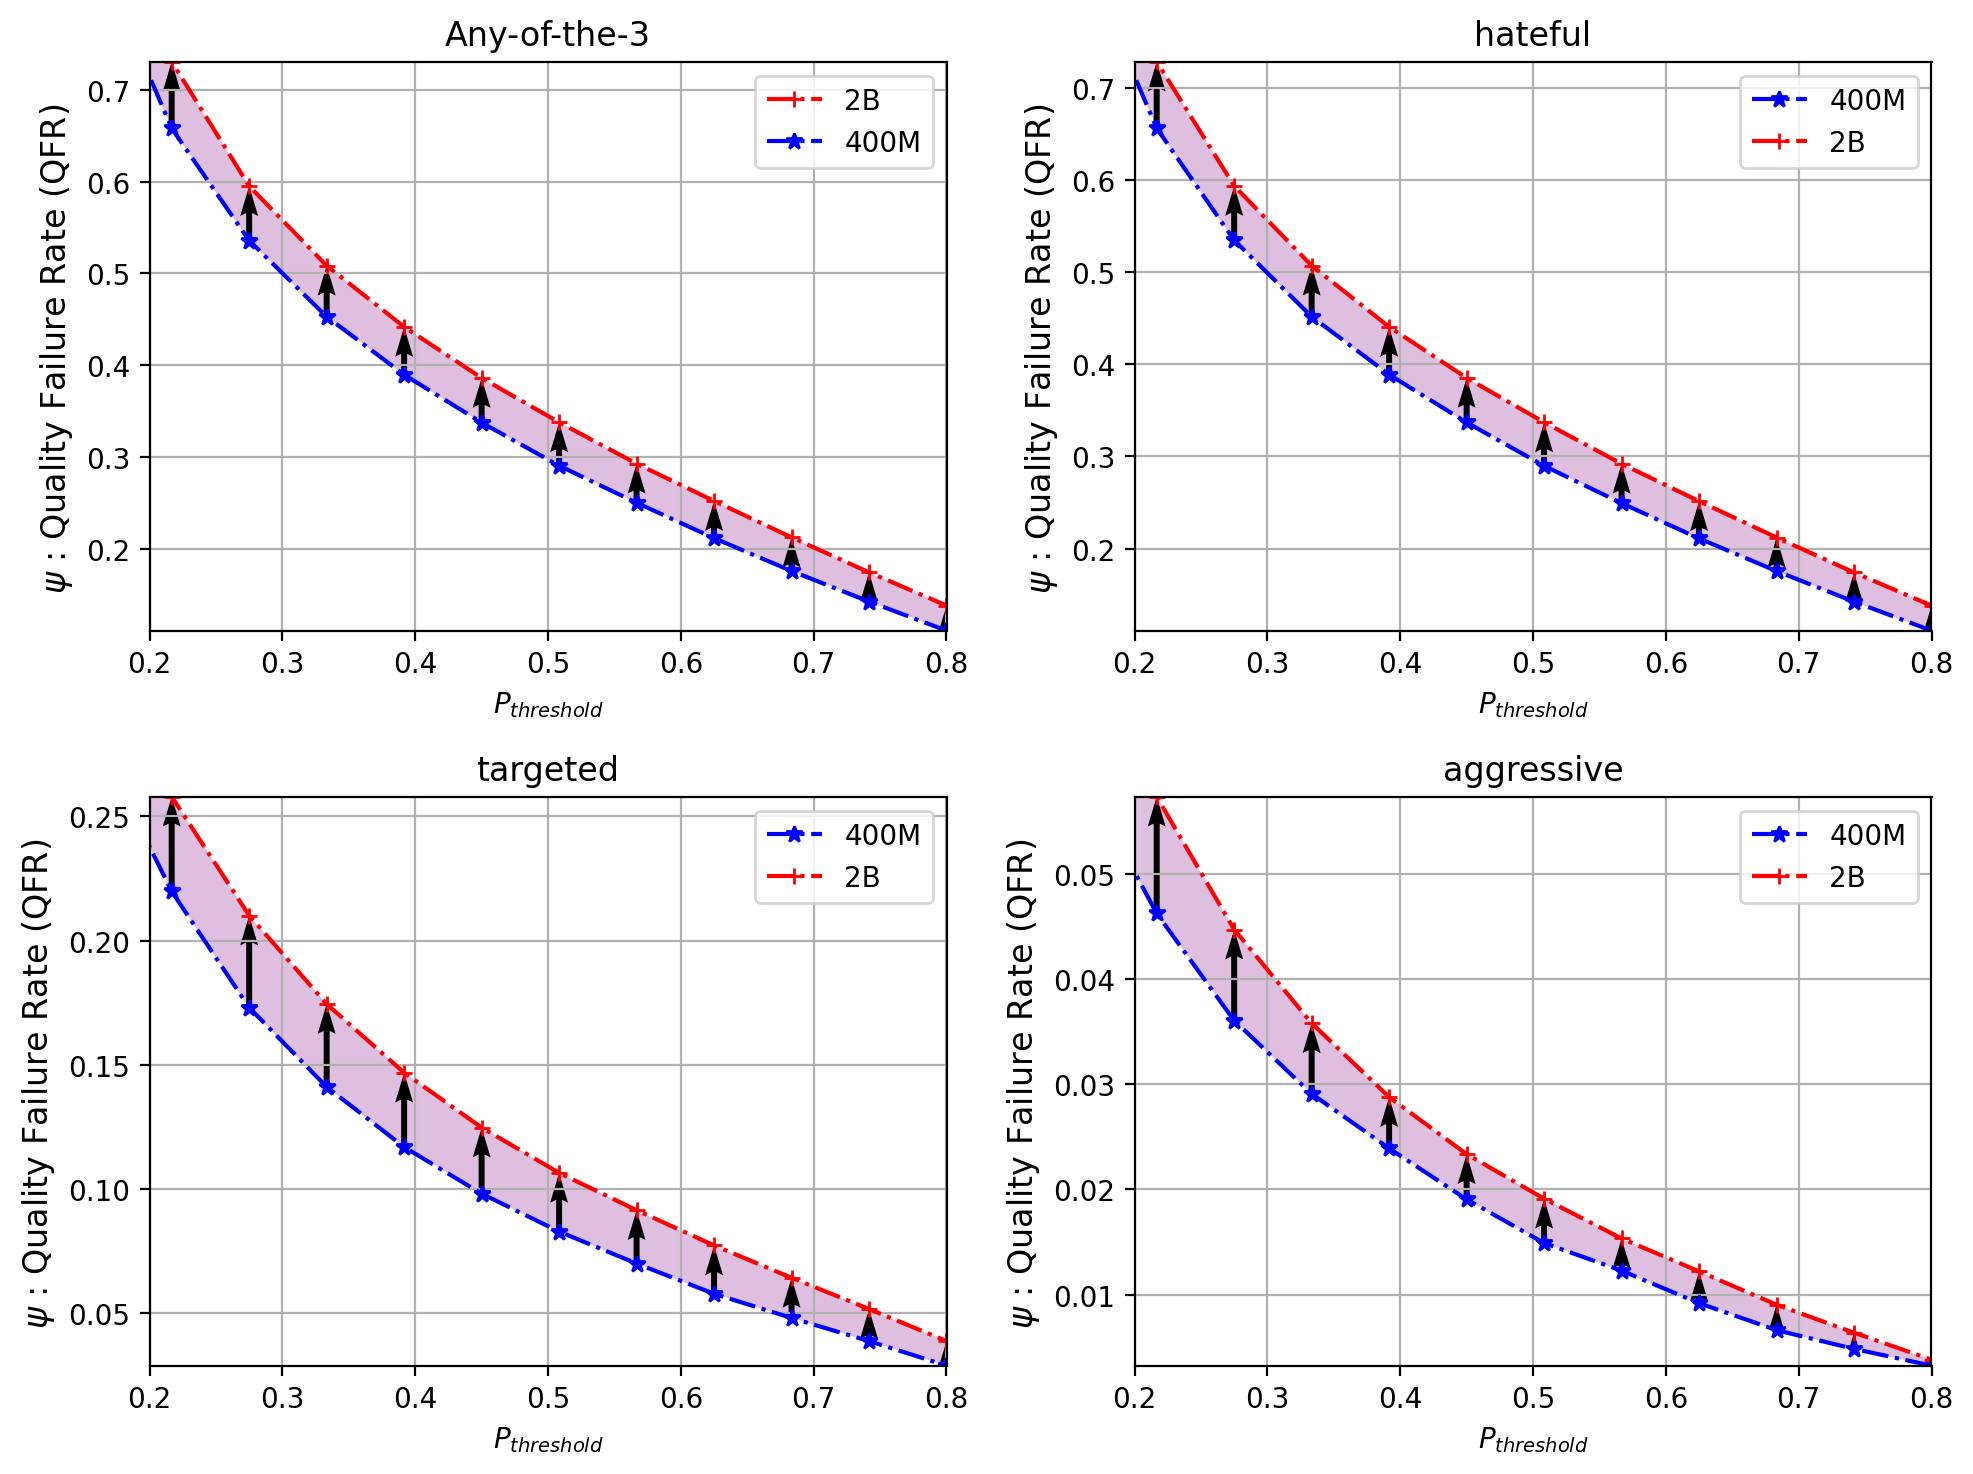

In [ ]:
thresh_vec=np.linspace(0.1,0.8,13)

type_vec=['hateful','targeted','aggressive']


p_detect=[]
for t in thresh_vec :
  p_detect.append(((np.max(p_400m,axis=1)>=t).mean()*100,(np.max(p_2b,axis=1)>=t).mean()*100))

p_detect_mat=np.array(p_detect)


plt.figure(figsize=(10,7.5))
plt.subplot(2,2,1)
plt.plot(thresh_vec[1:],p_detect_mat[1:,1],'-.r+',label='2B')
plt.plot(thresh_vec[1:],p_detect_mat[1:,0],'-.b*',label='400M')
plt.fill_between(thresh_vec[1:],p_detect_mat[1:,1],p_detect_mat[1:,0],facecolor='purple',alpha=0.25)
plt.quiver(thresh_vec[1:], p_detect_mat[1:,0],np.zeros(len( thresh_vec[1:])), p_detect_mat[1:,1]-p_detect_mat[1:,0], angles='xy', scale_units='xy',scale=1)
plt.ylabel(r'$\psi$ : Quality Failure Rate (QFR) ',fontsize=12)
plt.xlim([0.2,0.8])
plt.ylim([p_detect_mat[1:,0].min(),p_detect_mat[2:,1].max()])
plt.xlabel(r'$P_{threshold}$')
plt.grid('on')
plt.title('Any-of-the-3')
plt.legend()

for col in range(3):
  p_detect=[]
  for t in thresh_vec :
    p_detect.append(((p_400m[:,col]>=t).mean()*100,(p_2b[:,col]>=t).mean()*100))

  p_detect_mat=np.array(p_detect)
  plt.subplot(2,2,col+2)
  plt.plot(thresh_vec[1:],p_detect_mat[1:,0],'-.b*',label='400M')
  plt.plot(thresh_vec[1:],p_detect_mat[1:,1],'-.r+',label='2B')
  plt.fill_between(thresh_vec[1:],p_detect_mat[1:,1],p_detect_mat[1:,0],facecolor='purple',alpha=0.25)
  plt.quiver(thresh_vec[1:], p_detect_mat[1:,0],np.zeros(len( thresh_vec[1:])), p_detect_mat[1:,1]-p_detect_mat[1:,0], angles='xy', scale_units='xy',scale=1)
  plt.ylabel(r'$\psi$ : Quality Failure Rate (QFR) ',fontsize=12)
  plt.xlabel(r'$P_{threshold}$')
  plt.title(type_vec[col])
  plt.legend()
  plt.grid('on')
  plt.xlim([0.2,0.8])
  plt.ylim([p_detect_mat[1:,0].min(),p_detect_mat[2:,1].max()])

plt.tight_layout()

plt.savefig(f'./{PLOT_DIR}/p_detect.pdf',bbox_inches='tight')
plt.savefig(f'./{PLOT_DIR}/p_detect.png')

## $4(b) : The underestimation of QFR demonstration

This experiment demonstrates the perils of lazily extending QFR-results obtained from the 400M dataset to 2B-en dataset.

Let us begin by evaluating the basic stats of the probability-matrices for the two datasets ...

In [ ]:
from scipy.stats import describe
[describe(p_400m,axis=0), 
 describe(p_2b,axis=0),
 describe(np.max(p_400m,axis=1)>0.5),
 describe(np.max(p_2b,axis=1)>0.5),
(np.max(p_400m,axis=1)>0.5).sum(),(np.max(p_2b,axis=1)>0.5).sum()]

[DescribeResult(nobs=3200000, minmax=(array([0.012772, 0.004229, 0.005947]), array([0.989797, 0.967047, 0.926435])), mean=array([0.023121, 0.01369 , 0.010992]), variance=array([0.002097, 0.000644, 0.000117]), skewness=array([14.188024, 24.053369, 49.852103]), kurtosis=array([ 230.00002 ,  682.486148, 2964.930419])),
 DescribeResult(nobs=12800000, minmax=(array([0.012603, 0.004042, 0.005814]), array([0.989958, 0.969463, 0.929803])), mean=array([0.023415, 0.013671, 0.011115]), variance=array([0.002416, 0.0008  , 0.000147]), skewness=array([13.575286, 22.381957, 44.986851]), kurtosis=array([ 207.976843,  578.26839 , 2411.584679])),
 DescribeResult(nobs=3200000, minmax=(False, True), mean=0.0029790625, variance=0.002970188614805039, skewness=18.239491784416035, kurtosis=330.67906055378023),
 DescribeResult(nobs=12800000, minmax=(False, True), mean=0.003443828125, variance=0.003431968440967979, skewness=16.952226800977645, kurtosis=285.3779935117819),
 9533,
 44081]

There appears to be a marked increase in the mean values :(
To check the validity of this observation, let us estimate CIs (Confidence Intervals) for this binomial proportion observation set

In [ ]:
from statsmodels.stats.proportion import proportion_confint

u_400m=np.mean(np.max(p_400m,axis=1)>0.5)*100 # QFR at 0.5 for the 400M dataset
u_2b=np.mean(np.max(p_2b,axis=1)>0.5)*100# QFR at 0.5 for the 2B-en dataset

count_400m=(np.max(p_400m,axis=1)>0.5).sum()
count_2b= (np.max(p_2b,axis=1)>0.5).sum()

ci_400m=np.array(proportion_confint(count=count_400m,nobs=p_400m.shape[0],alpha=0.05,method='wilson'))*100
ci_2b=np.array(proportion_confint(count=count_2b,nobs=p_2b.shape[0],alpha=0.05,method='wilson'))*100

u_400m,ci_400m,u_2b,ci_2b

(0.29790625,
 array([0.291994, 0.303937]),
 0.34438281249999997,
 array([0.341188, 0.347607]))

Wow!
Let estimate the percentage increase b/w the 2B-en and 400M datasets as $\frac{CI_{lower,2B}-CI_{upper,400M}}{CI_{upper,400M}}$

In [ ]:
perc_increase=((ci_2b[0]-ci_400m[1])/ci_400m[1])*100
perc_increase

12.256104173239814

In [ ]:
n_400m=413e6
n_2b=2.32e9

ci_toxic_400m=n_400m*np.array(ci_400m)/100
ci_toxic_2b=n_2b*np.array(ci_2b)/100
ci_misestimate=n_2b*np.array(ci_400m)/100

print(ci_toxic_400m, ci_toxic_2b , ci_misestimate )

[1205936.76227  1255261.696449] [7915569.675695 8064484.292879] [6774269.463597 7051348.997003]


Moving from CIs to estimating the number of excess toxic-images:

In [ ]:
n_diff=int(((n_2b*ci_2b[0])-(n_2b*ci_400m[1]))/100)
n_diff

864220

In [ ]:
# mid-point analysis:
[u_400m,u_2b],[np.diff(ci_400m)[0]/2,np.diff(ci_2b)[0]/2]

([0.29790625, 0.34438281249999997],
 [0.005971541668241931, 0.0032093667496668754])

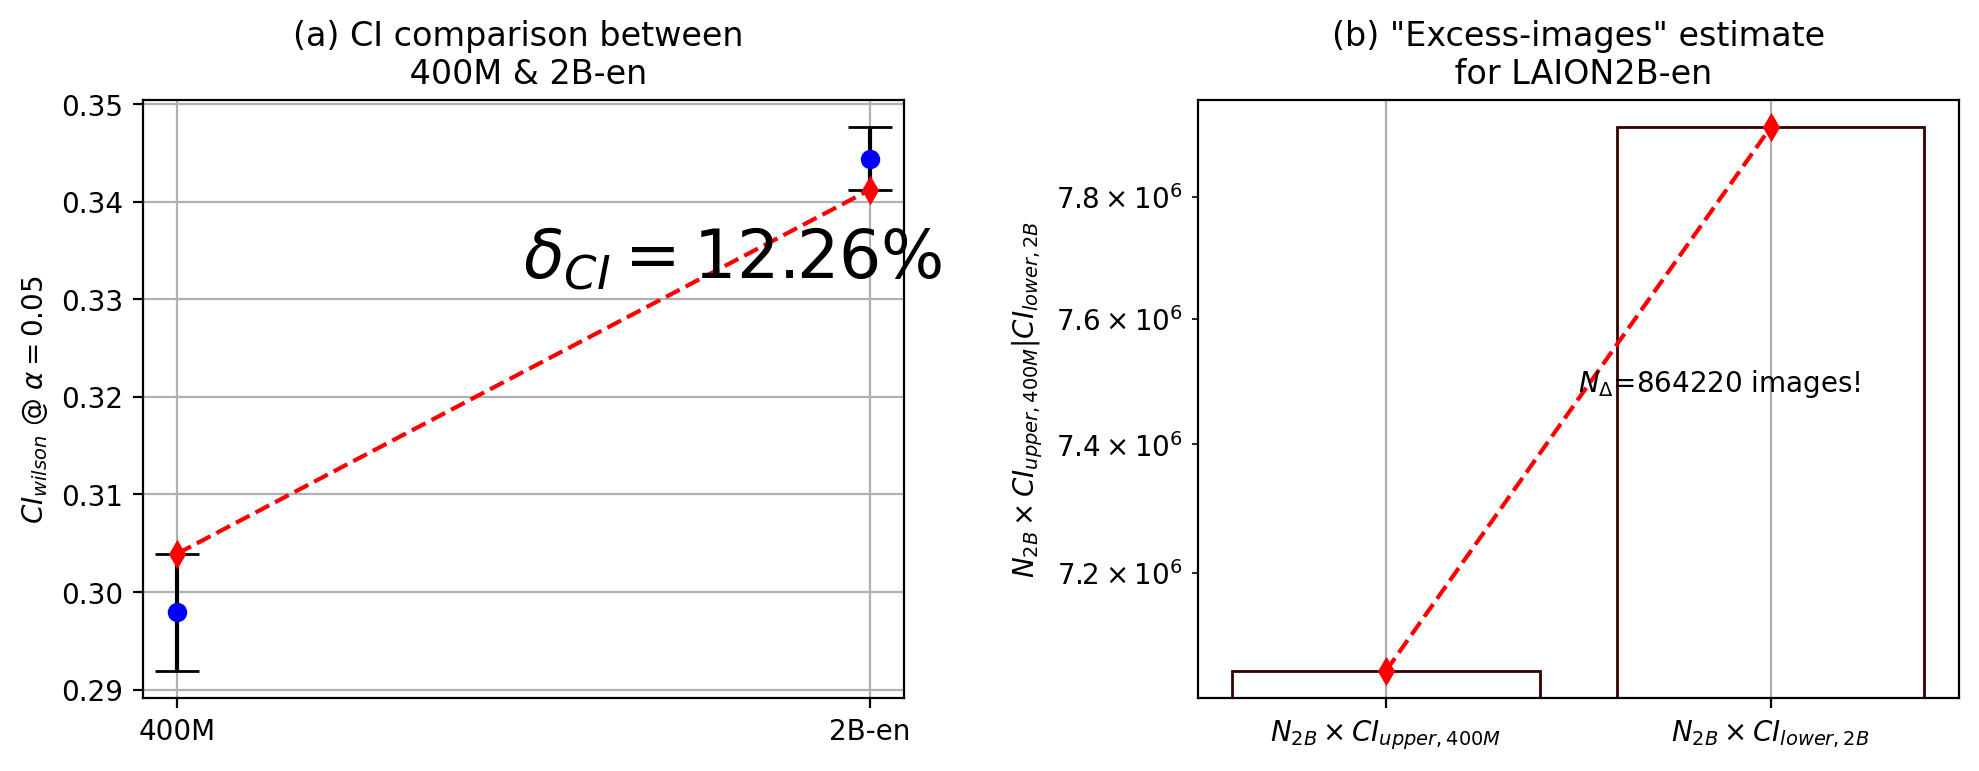

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.errorbar([0,1],[u_400m,u_2b],[np.diff(ci_400m)[0]/2,np.diff(ci_2b)[0]/2],linestyle='None',  fmt="ob",  capsize=8,  ecolor="k")
plt.xticks([0,1],['400M','2B-en'])
plt.ylabel(r'$CI_{wilson}$ @ $\alpha=0.05$')
plt.grid('on')
point1 = [0, ci_400m[1]]
point2 = [1, ci_2b[0]]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'rd', linestyle="--")
plt.text(point2[0]-0.5, point2[1]-0.009, f"$\delta_{{CI}}=${np.round(perc_increase,2)}%",fontsize=24)
plt.title('(a) CI comparison between \n 400M & 2B-en')


plt.subplot(122)
plt.bar([0,1],[int(n_2b*ci_400m[1]/100),int(n_2b*ci_2b[0])/100],fill=False,color='#330000',edgecolor='#330000')
plt.xticks([0,1],[r'$N_{2B} \times CI_{upper,400M}$',r'$N_{2B} \times CI_{lower,2B}$'])
plt.semilogy()

plt.grid('on')
plt.ylabel(r'$N_{2B} \times CI_{upper,400M} | CI_{lower,2B}$')
point1 = [0, int(n_2b*ci_400m[1]/100)]
point2 = [1, int(n_2b*ci_2b[0]/100)]
x_values = [point1[0], point2[0]]
y_values = [point1[1], point2[1]]
plt.plot(x_values, y_values, 'rd', linestyle="--")
plt.text(0.5, point1[1]+(point2[1]-point1[1])/2, rf"$N_{{\Delta}}$={n_diff} images!")
plt.title('(b) "Excess-images" estimate\n for LAION2B-en')
plt.tight_layout()
plt.savefig(f'./{PLOT_DIR}/n_excess.pdf',bbox_inches='tight')
plt.savefig(f'./{PLOT_DIR}/n_excess.png')



## $4(c): Intra-dataset filewise comparisons (Welch separate variances T-testframework)

Given that the two datasets, LAION-400M and LAION-2B-En, are split into 32 (and 128)
purportedly uniformly sampled shards, respectively, we now examine the validity of the filelevel QFR metrics to the global dataset-level metrics. We use the 0.1 million × 3 sized
file-level text-quality score matrices obtained from the Pysentimiento model and compute
what fraction of these rows are greater than Pthreshold of 0.5 for all the 3 columns. This yields
file-level QFRs (in%) for each of the two datasets with the 3 columns mapping to hateful
speech, targeted speech and aggressive speech.

In [ ]:
!pip install --quiet pingouin
# # https://ethanweed.github.io/pythonbook/05.02-ttest.html#the-independent-samples-t-test-welch-test

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from pingouin import ttest
p_400m_max=np.max(p_400m,axis=1)
p_2b_max=np.max(p_2b,axis=1)
describe(p_400m_max),describe(p_2b_max)
ttest(p_2b_max,p_400m_max, correction = False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,9.715382,15999998,two-sided,2.593127e-22,"[0.0, 0.0]",0.006072,2.211e+17,1.0


 Quick sanity check: Hand-estimate Cohen's-d to verify the pingouin generated one

In [ ]:
n1=len(p_2b_max)
n2=len(p_400m_max)

u1=np.mean(p_2b_max)
u2=np.mean(p_400m_max)

s1=np.var(p_2b_max)
s2=np.var(p_400m_max)

s = np.sqrt(((n1) * s1 + (n2) * s2) / (n1 + n2 - 2))

# calculate Cohen's d
d = (u1 - u2) / s
d

0.006072113544001382

In [ ]:
p_05_400m=(p_400m>0.5)
res = np.logical_or.reduce(p_05_400m, 1).astype(np.int32)
res.shape,res.mean()

((3200000,), 0.0029790625)

File-level analysis: 

First let us load the file-level meta-datasets

In [ ]:
qfr_all=np.load(f'{RESULT_DIR}/qfr_400m_2Ben.npy')
prob_mat_400m=qfr_all[0:32,:]
prob_mat_2b=qfr_all[32:,:]
prob_mat_400m.shape,prob_mat_2b.shape,describe(prob_mat_400m[:,0]),describe(prob_mat_2b[:,0])

((32, 3),
 (128, 3),
 DescribeResult(nobs=32, minmax=(0.263, 0.335), mean=0.29703124999999997, variance=0.0002486118951612903, skewness=0.06991722797729315, kurtosis=0.20343492760156678),
 DescribeResult(nobs=128, minmax=(0.297, 0.382), mean=0.34355468749999996, variance=0.0003268788754921259, skewness=-0.13178099286037637, kurtosis=-0.5861293594344628))

Now, let us see what percentage of the files fall within 2 SD of the population mean

In [ ]:
coverage_400m=[]
for i in range(3):
  u_i=prob_mat_400m[:,i].mean()
  s_i=prob_mat_400m[:,i].std()
  coverage_400m.append(np.mean(((u_i-2*s_i) < prob_mat_400m[:,i]) & (prob_mat_400m[:,i]<(u_i+2*s_i))))

coverage_2b=[]
for i in range(3):
  u_i=prob_mat_2b[:,i].mean()
  s_i=prob_mat_2b[:,i].std()
  coverage_2b.append(np.mean(((u_i-2*s_i) < prob_mat_2b[:,i]) & (prob_mat_2b[:,i]<(u_i+2*s_i))))

coverage_400m,coverage_2b

([0.9375, 0.9375, 0.96875], [0.9609375, 0.9609375, 0.9453125])

Neat! Now, we perform a two-sample t-test while correcting for unequal variances (using the
Welch separate variances T-test) and explicitly setting the alternative hypothesis set to be
‘greater’ (with respect to the alternate hypothesis that the mean of the 2B-en QFRs is greater than the mean of 400M-QFRs)

In [ ]:
df_t0=ttest(prob_mat_2b[:,0],prob_mat_400m[:,0], correction = True,alternative='greater')
df_t1=ttest(prob_mat_2b[:,1],prob_mat_400m[:,1], correction = True,alternative='greater')
df_t2=ttest(prob_mat_2b[:,2],prob_mat_400m[:,2], correction = True,alternative='greater')

df_t=pd.concat([df_t0,df_t1,df_t2],ignore_index=True)
df_t.index=['hateful','targeted','aggressive']
df_t

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
hateful,14.480105,53.322774,greater,2.019874e-20,"[0.04, inf]",2.635888,3.785e+27,1.00000
targeted,13.804601,54.908542,greater,8.443671e-20,"[0.02, inf]",2.465005,5.957e+25,1.00000
aggressive,4.444020,47.962383,greater,2.601226e-05,"[0.0, inf]",0.874567,2131.144,0.99712


OK. So, this needs to be prettied up for the tables that appear in the paper ...

In [ ]:
pd.options.display.precision==2
df_t.iloc[:,[0,1,5,6]]=np.round(df_t.iloc[:,[0,1,5,6]],2)
print(df_t.iloc[:,[0,1,3,5,6]].to_latex())

\begin{tabular}{lrrrrl}
\toprule
{} &      T &    dof &         p-val &  cohen-d &       BF10 \\
\midrule
hateful    &  14.48 &  53.32 &  2.019874e-20 &     2.64 &  3.785e+27 \\
targeted   &  13.80 &  54.91 &  8.443671e-20 &     2.47 &  5.957e+25 \\
aggressive &   4.44 &  47.96 &  2.601226e-05 &     0.87 &   2131.144 \\
\bottomrule
\end{tabular}



<ipython-input-33-cd5b4c3920df>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_t.iloc[:,[0,1,3,5,6]].to_latex())


In [ ]:
print(df_t.to_latex())

\begin{tabular}{lrrlrlrlr}
\toprule
{} &      T &    dof & alternative &         p-val &        CI95\% &  cohen-d &       BF10 &    power \\
\midrule
hateful    &  14.48 &  53.32 &     greater &  2.019874e-20 &  [0.04, inf] &     2.64 &  3.785e+27 &  1.00000 \\
targeted   &  13.80 &  54.91 &     greater &  8.443671e-20 &  [0.02, inf] &     2.47 &  5.957e+25 &  1.00000 \\
aggressive &   4.44 &  47.96 &     greater &  2.601226e-05 &   [0.0, inf] &     0.87 &   2131.144 &  0.99712 \\
\bottomrule
\end{tabular}



<ipython-input-34-a389fe1a1304>:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_t.to_latex())


### Final step:  

Generating Fused swarm-box-violinplot that captures the file-wise QFR metrics for all the 160
(=32+128) parquet files from LAION400M and LAION-2B-En

In [ ]:
df_files_400m=pd.DataFrame(data=np.ravel(prob_mat_400m),columns=['p_sentimento'])
df_files_400m['type']=['P_hateful', 'P_targeted', 'P_aggressive']*32
df_files_400m['dataset']='400M'
df_files_400m

,p_sentimento,type,dataset
0,0.294,P_hateful,400M
1,0.097,P_targeted,400M
2,0.017,P_aggressive,400M
3,0.300,P_hateful,400M
4,0.069,P_targeted,400M
...,...,...,...
91,0.086,P_targeted,400M
92,0.024,P_aggressive,400M
93,0.326,P_hateful,400M
94,0.097,P_targeted,400M


In [ ]:
df_files_2b=pd.DataFrame(data=np.ravel(prob_mat_2b),columns=['p_sentimento'])
df_files_2b['type']=['P_hateful', 'P_targeted', 'P_aggressive']*128
df_files_2b['dataset']='2B-En'
df_files_2b

,p_sentimento,type,dataset
0,0.361,P_hateful,2B-En
1,0.093,P_targeted,2B-En
2,0.014,P_aggressive,2B-En
3,0.338,P_hateful,2B-En
4,0.110,P_targeted,2B-En
...,...,...,...
379,0.098,P_targeted,2B-En
380,0.012,P_aggressive,2B-En
381,0.327,P_hateful,2B-En
382,0.094,P_targeted,2B-En


In [ ]:
df_comb=pd.concat([df_files_400m,df_files_2b],ignore_index=True)
df_comb

,p_sentimento,type,dataset
0,0.294,P_hateful,400M
1,0.097,P_targeted,400M
2,0.017,P_aggressive,400M
3,0.300,P_hateful,400M
4,0.069,P_targeted,400M
...,...,...,...
475,0.098,P_targeted,2B-En
476,0.012,P_aggressive,2B-En
477,0.327,P_hateful,2B-En
478,0.094,P_targeted,2B-En


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 38.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-38-2f38fa32df50>:32: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('blue')
<ipython-input-38-2f38fa32df50>:33: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('red')
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3544: UserWarning: 38.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


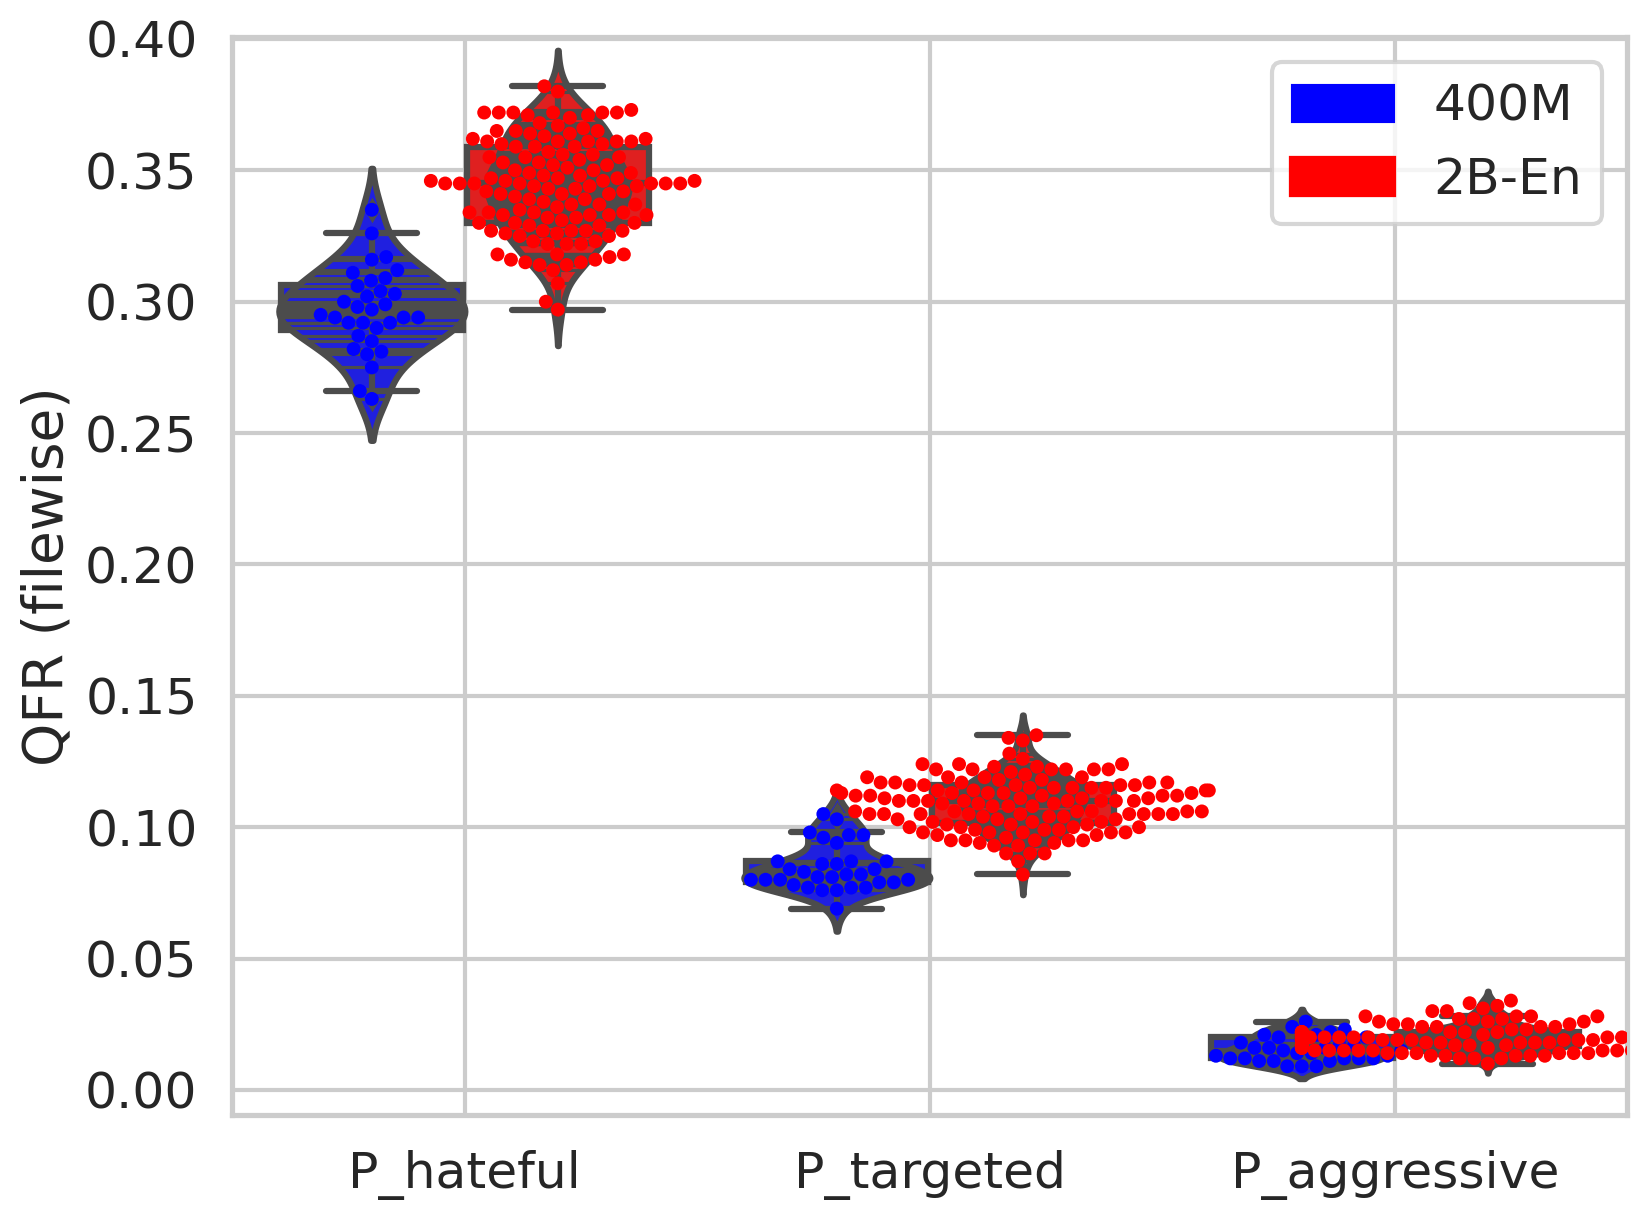

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("talk", font_scale=1.1)
plt.figure(figsize=(9,7))
g=sns.violinplot(x = "type",
            y = "p_sentimento",
            hue="dataset",
            inner='stick',
            data = df_comb,legend=False,
            palette=sns.color_palette(['blue', 'red']))

g=sns.boxplot(x = "type",
            y = "p_sentimento",
            hue="dataset",
            data = df_comb,
            palette=sns.color_palette(['blue', 'red'])
            )
sns.swarmplot(x = "type",
            y = "p_sentimento",color="white",
            hue="dataset",
            data = df_comb, dodge=True,
            palette=sns.color_palette(['blue', 'red']),legend=False)

plt.ylabel(r'QFR (filewise)')
plt.xlabel('')
ax = plt.gca()
ax.get_legend().remove()

plt.legend(['400M','2B-En'])

leg = ax.get_legend()
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid('on')

plt.savefig(f'./{PLOT_DIR}/filewise_violin.pdf',bbox_inches='tight')
plt.savefig(f'./{PLOT_DIR}/filewise_violin.png')

##################################################

In [ ]:
import psutil
split_bar = '='*20
memory_info = psutil.virtual_memory()._asdict()
print(f"{split_bar} Memory Usage {split_bar}")
for k,v in memory_info.items():
  print(k, v)
print(f"{split_bar} CPU Usage {split_bar}")
print(f"CPU percent: {psutil.cpu_percent()}%")
import gc
del [df_2b_0,df_400m_0,p_2b,p_400m,p_05_400m]
gc.collect()

==================== Memory Usage ====================
total 89636782080
available 71387934720
percent 20.4
used 17304924160
free 46916997120
active 891756544
inactive 40490192896
buffers 377651200
cached 25037209600
shared 20992000
slab 674902016
==================== CPU Usage ====================
CPU percent: 11.9%


484

# Last step: Verification

This entails reloading a random raw parquet files manually, re-running the NLP hate classifier and comparing the output of the classifier to the data-assets already curated

In [ ]:
analyzer = create_analyzer(task="hate_speech", lang="en")
# Create a fresh list from scratch
parquet_list=[]
import os
for root, dirs, files in os.walk('./the-eye.eu'):
    for file in files:
        if file.endswith(".snappy.parquet"):
             parquet_list.append(os.path.join(root, file))
# Pick a random file
ind_random_400m=np.random.choice(len(parquet_list),1,replace=False)[0]
file_interested=parquet_list[ind_random_400m]
# Covert file name to ``ind_i`` to fetch the pre-computed results
ind_i=file_interested.split('/')[-2]+'_'+file_interested.split('/')[-1].split('-')[1]
# Load the pre-computed results
ind_vec=np.load(f'./{RESULT_DIR}/index_random_{ind_i}.npy')
prob_hate_file=np.load(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy')
qfr_file=np.load(f'./{RESULT_DIR}/qfr_file_{ind_i}.npy')
############################################################
# Now, let us manually re-read the file and run the inference again to verify.
t = TicToc()
import pyarrow.parquet as pq
t.tic()
df_i = pd.read_parquet(file_interested)
t.toc()
print(df_i.head(4))
N_s=int(1e5)
# Step-2b: Extract the text-description from these indices
texts_np_i = df_i.iloc[ind_vec].TEXT.astype(str).values[0:N_s]
print(texts_np_i)
# Step-3: Analyze the textual-content ( 1x3 o/p [P_hateful, P_targeted, P_aggressive])
del df_i
gc.collect()
t.tic()
results_i=analyzer.predict(texts_np_i)
t.toc()
# Compute the results
prob_hate_recomputed=np.array(list(itertools.chain.from_iterable(x.probas.values() for x in results_i))).reshape(N_s,3)
qfr_recomputed=np.mean(prob_hate_recomputed>0.5,axis=0)*100
# Verification:
np.testing.assert_allclose(prob_hate_recomputed, prob_hate_file,rtol=1e-03,), np.testing.assert_allclose(qfr_recomputed,qfr_file,rtol=1e-03,)

Elapsed time is 25.858529 seconds.
      SAMPLE_ID                                                URL  \
0  9.517220e+11  https://www.animalhub.com/wp-content/uploads/2...   
1  1.040576e+12  https://underarmour.scene7.com/is/image/Undera...   
2  2.108630e+12    http://i.ytimg.com/vi/xqv_0xZjMnM/hqdefault.jpg   
3  1.143238e+12  http://file2.okorder.com/prodalbum/2015/07/31/...   

                                                TEXT  HEIGHT  WIDTH LICENSE  \
0             High-Quality Dog Collars And Harnesses   150.0  150.0       ?   
1  Girls' UA Novelty Big Logo T-Shirt  1 Color $2...   281.0  345.0       ?   
2  When you're Never Lucky..!! | Hearthstone Un'G...   480.0  360.0       ?   
3              LED STRIP LIGHT SMD5630 SMD5730 WW-CW   300.0  300.0       ?   

       NSFW  similarity  
0  UNLIKELY    0.325570  
1  UNLIKELY    0.325258  
2  UNLIKELY    0.357391  
3  UNLIKELY    0.334829  
['Mouse Genius DX-110 USB' 'DEEDS.WORLD'
 '1988 Donruss 398 Willie Hernandez' ... 'Kenwo

Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 117.246132 seconds.


(None, None)

Now, repeat the verification for the 2B-en dataset

In [ ]:
analyzer = create_analyzer(task="hate_speech", lang="en")
# Create a fresh list from scratch
parquet_list=[]
import os
for root, dirs, files in os.walk('./LAION-2Ben/'):
    for file in files:
        if file.endswith(".snappy.parquet"):
             parquet_list.append(os.path.join(root, file))
# Pick a random file
ind_random_2b=np.random.choice(len(parquet_list),1,replace=False)[0]
file_interested=parquet_list[ind_random_2b]
# Covert file name to ``ind_i`` to fetch the pre-computed results
ind_i=file_interested.split('/')[-2]+'_'+file_interested.split('/')[-1].split('-')[1]
# Load the pre-computed results
ind_vec=np.load(f'./{RESULT_DIR}/index_random_{ind_i}.npy')
prob_hate_file=np.load(f'./{RESULT_DIR}/prob_hate_{ind_i}.npy')
qfr_file=np.load(f'./{RESULT_DIR}/qfr_file_{ind_i}.npy')
############################################################
# Now, let us manually re-read the file and run the inference again to verify.
t = TicToc()
import pyarrow.parquet as pq
t.tic()
df_i = pd.read_parquet(file_interested)
t.toc()
print(df_i.head(4))
N_s=int(1e5)
# Step-2b: Extract the text-description from these indices
texts_np_i = df_i.iloc[ind_vec].TEXT.astype(str).values[0:N_s]
print(texts_np_i)
# Step-3: Analyze the textual-content ( 1x3 o/p [P_hateful, P_targeted, P_aggressive])
del df_i
gc.collect()
t.tic()
results_i=analyzer.predict(texts_np_i)
t.toc()
# Compute the results
prob_hate_recomputed=np.array(list(itertools.chain.from_iterable(x.probas.values() for x in results_i))).reshape(N_s,3)
qfr_recomputed=np.mean(prob_hate_recomputed>0.5,axis=0)*100
# Verification:
np.testing.assert_allclose(prob_hate_recomputed, prob_hate_file,rtol=1e-03,), np.testing.assert_allclose(qfr_recomputed,qfr_file,rtol=1e-03,)

Elapsed time is 66.969910 seconds.
      SAMPLE_ID                                                URL  \
0  2.571069e+12  https://gearnuke.com/wp-content/uploads/2016/0...   
1  1.136837e+12  https://www.cypruspropertyforsale.com/modules/...   
2  2.302378e+12  https://ph-live-01.slatic.net/p/7/welink-fashi...   
3  2.374022e+12  https://www.pittman.ie/media/catalog/product/p...   

                                                TEXT  HEIGHT  WIDTH LICENSE  \
0           Counter-Strike-Esl-One-cologne-SK-Gaming   600.0  337.0       ?   
1                           Cyprus property for sale   198.0  226.0       ?   
2  Welink Fashion Silicone US Keyboard Cover Wate...   340.0  340.0       ?   
3         Electric shock emergency action wall panel   600.0  600.0       ?   

       NSFW  similarity  
0  UNLIKELY    0.315052  
1  UNLIKELY    0.384769  
2  UNLIKELY    0.314573  
3  UNLIKELY    0.328980  
['Met-Rx USA Liquid L-Carnitine 1500'
 'Yamaha MG 24:6 mixing desk (good working desk)'


Map:   0%|          | 0/100000 [00:00<?, ? examples/s]

Elapsed time is 125.527857 seconds.


(None, None)

Last stage:
In case you are wondering how the NLP-classifier triggered alt-text descriptions look like, here are a few examples:
🤮

In [ ]:
texts_np_i[np.argsort(-prob_hate_file[:,0])[0:20]]

array(['Amateur mother suck and fuck fat young cock',
       'Mature housewife fists and stretch her cunt with giant dildo',
       'Latex slut gets tied and fisted in both holes',
       'MMMM I wanna suck his cock as she does that with her boots.',
       'Extreme amateur slut takes a huge fist fucking in her drooling loose cunt...',
       'Slender leggy Turkish babe Anya Krey is sucking a big dick and getting her pussy nailed hard',
       'Hot Auntie_Yasmin Scott suck her nephews cock Preview Image',
       'Black Haired Sweet Bitch In Sexy Fishnets Sucks Big Cock Sitting Under The Milking Table',
       'Spanked Skank Sucking Balls After Pounding',
       'MILF gets caught stealing and cop records fucking her- Brooke Lyn Rose',
       'Hory and slutty whore with nice shape and good boobs gets her dripping hole fucked mish on the bed. Have a look in steamy The Indian Porn xxx clip.',
       'Big ass blonde whore pounded by pawn guy to earn extra money',
       'Horny granny teased